#### Imports & Downloads

In [103]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgboost
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
import vectorize_functions

from sklearn.metrics import mean_squared_error
import time
import optuna

from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances
from typing import Tuple
from sklearn.metrics import log_loss
from optuna.samplers import TPESampler

### Einladen der vektorisierten Daten - TFIDF

In [206]:
X_train, X_test, y_train, y_test = vectorize_functions.vectorize_tfidf()

In [207]:
positive = np.count_nonzero(y_train == 1)
negative = np.count_nonzero(y_train == 0)
print("Train")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

positive = np.count_nonzero(y_test == 1)
negative = np.count_nonzero(y_test == 0)
print("Test")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

Train
- Positive: 1270
- Negative: 18084
- Verhältnis: 14.239370078740157
Test
- Positive: 541
- Negative: 7754
- Verhältnis: 14.33271719038817


In [208]:
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (19354, 6293)
y_train shape (19354,)
X_test shape (8295, 6293)
y_test shape (8295,)


### 2. Ensemble Models

In [212]:
evaluation = pd.DataFrame(
    columns=["model", "variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc", "test_prec",
             "test_rec", "test_f1"])

In [108]:
def add_to_eval_df(model, model_name, variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, variant, train_acc, train_precision, train_recall, train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [109]:
def evaluate_model(model, x_test, y_test, sampling_method):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'{sampling_method} model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### 2.1 Bagging

##### 2.1.1 RandomForest

###### RandomForest no tuning

In [110]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 95.78%
------------------------------------------------
Confusion Matrix:
      0    1
0  7706   48
1   302  239
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7754
           1       0.83      0.44      0.58       541

    accuracy                           0.96      8295
   macro avg       0.90      0.72      0.78      8295
weighted avg       0.95      0.96      0.95      8295



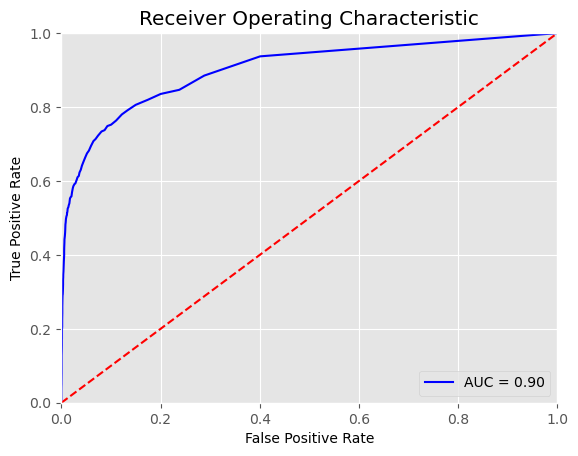

In [214]:
evaluate_model(rf, X_test, y_test, "none")
add_to_eval_df(rf, "RandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [112]:
cv = cross_val_score(rf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.511) total time=  21.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.4s remaining:    0.0s


[CV] END ................................ score: (test=0.510) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.2s remaining:    0.0s


[CV] END ................................ score: (test=0.533) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.0s remaining:    0.0s


[CV] END ................................ score: (test=0.526) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   31.4s remaining:    0.0s


[CV] END ................................ score: (test=0.551) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.7s remaining:    0.0s


[CV] END ................................ score: (test=0.480) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   38.4s remaining:    0.0s


[CV] END ................................ score: (test=0.544) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   41.8s remaining:    0.0s


[CV] END ................................ score: (test=0.546) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   45.0s remaining:    0.0s


[CV] END ................................ score: (test=0.569) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   47.7s remaining:    0.0s


[CV] END ................................ score: (test=0.538) total time=   2.6s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   50.4s finished


In [113]:
np.mean(cv)

0.53078702366625

###### RandomForest tuning (GridSearchCV)

In [114]:
# todo

###### RandomForest tuning (RandomizedSearchCV)

In [115]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [116]:
random_search = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=10)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=3, max_features=None, max_leaf_nodes=9, n_estimators=200
[CV 1/5; 1/10] END max_depth=3, max_features=None, max_leaf_nodes=9, n_estimators=200;, score=0.213 total time=   2.4s
[CV 2/5; 1/10] START max_depth=3, max_features=None, max_leaf_nodes=9, n_estimators=200
[CV 2/5; 1/10] END max_depth=3, max_features=None, max_leaf_nodes=9, n_estimators=200;, score=0.177 total time=   2.5s
[CV 3/5; 1/10] START max_depth=3, max_features=None, max_leaf_nodes=9, n_estimators=200
[CV 3/5; 1/10] END max_depth=3, max_features=None, max_leaf_nodes=9, n_estimators=200;, score=0.147 total time=   2.4s
[CV 4/5; 1/10] START max_depth=3, max_features=None, max_leaf_nodes=9, n_estimators=200
[CV 4/5; 1/10] END max_depth=3, max_features=None, max_leaf_nodes=9, n_estimators=200;, score=0.236 total time=   2.5s
[CV 5/5; 1/10] START max_depth=3, max_features=None, max_leaf_nodes=9, n_estimators=200
[CV 5/5; 1/10] END max_

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1', verbose=10)

In [117]:
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,
                       n_estimators=250, n_jobs=-1)


In [118]:
rf_tuned = RandomForestClassifier(**random_search.best_params_)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,
                       n_estimators=250)

none model accuracy for classification is = 94.51%
------------------------------------------------
Confusion Matrix:
      0    1
0  7724   30
1   425  116
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.79      0.21      0.34       541

    accuracy                           0.95      8295
   macro avg       0.87      0.61      0.65      8295
weighted avg       0.94      0.95      0.93      8295



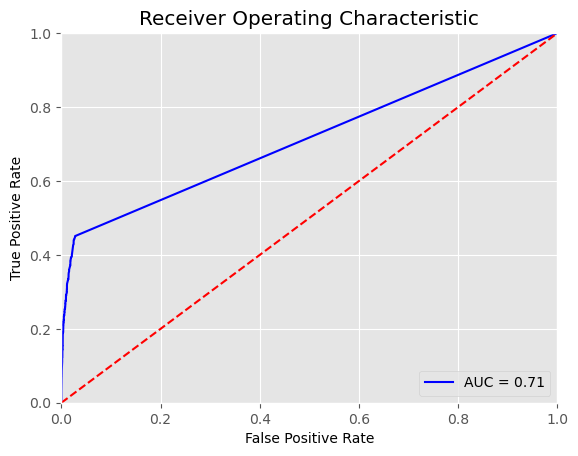

In [119]:
evaluate_model(rf_tuned, X_test, y_test, "none")
add_to_eval_df(rf_tuned, "RandomForestClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### RandomForest tuning (optuna)
https://gist.github.com/shamilnabiyev/c1b6e23444a949bc45243eab445a3806

In [174]:
def objective_rf(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=50)
    max_depth = trial.suggest_int(name="max_depth", low=10, high=150, step=5)
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)

    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }
    model = RandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1')
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

In [175]:
sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study_rf = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
study_rf.optimize(objective_rf, n_trials=50)

[I 2024-11-24 11:20:37,208] A new study created in memory with name: no-name-4fc1acca-bdec-433a-920a-626dbb2498b1
[I 2024-11-24 11:21:39,744] Trial 0 finished with value: 0.31835293192531455 and parameters: {'n_estimators': 250, 'max_depth': 145, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.31835293192531455.
[I 2024-11-24 11:21:47,458] Trial 1 finished with value: 0.05354801346215332 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.31835293192531455.
[I 2024-11-24 11:22:32,341] Trial 2 finished with value: 0.2616067272986254 and parameters: {'n_estimators': 350, 'max_depth': 110, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.31835293192531455.
[I 2024-11-24 11:23:19,544] Trial 3 finished with value: 0.13848324246725674 and parameters: {'n_estimators': 450, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 wi

Number of finished trials: 50
Best trial:
  Value: 0.4469881015036633
  Params: 
    n_estimators: 250
    max_depth: 150
    min_samples_split: 8
    min_samples_leaf: 1


C:\Users\admin\AppData\Local\Temp\ipykernel_20112\2334329262.py:12: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_rf)
C:\Users\admin\AppData\Local\Temp\ipykernel_20112\2334329262.py:13: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_rf)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

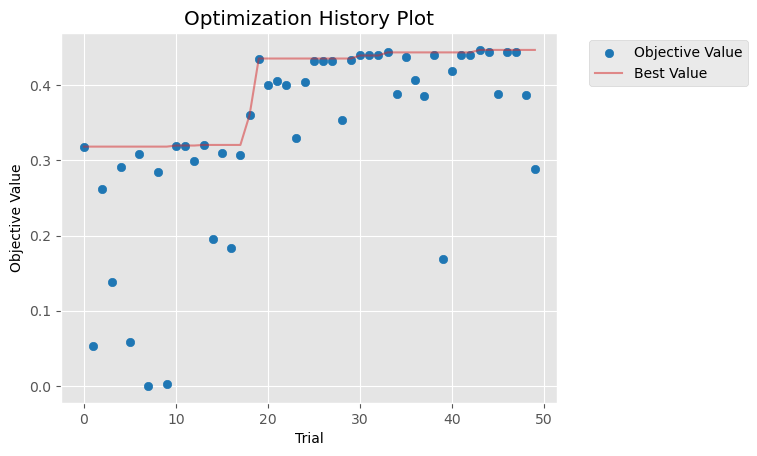

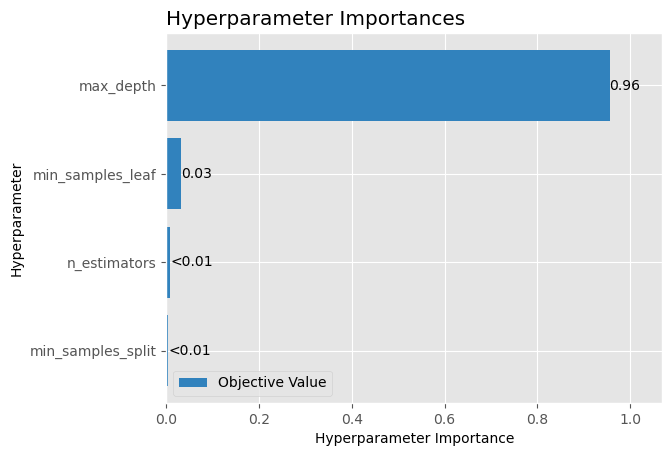

In [176]:
print("Number of finished trials: {}".format(len(study_rf.trials)))

print("Best trial:")
trial = study_rf.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

plot_optimization_history(study_rf)
plot_param_importances(study_rf)

In [215]:
rf_tuned_optuna = RandomForestClassifier(**study_rf.best_trial.params)
rf_tuned_optuna.fit(X_train, y_train)

ValueError: No trials are completed yet.

none model accuracy for classification is = 95.44%
------------------------------------------------
Confusion Matrix:
      0    1
0  7724   30
1   348  193
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7754
           1       0.87      0.36      0.51       541

    accuracy                           0.95      8295
   macro avg       0.91      0.68      0.74      8295
weighted avg       0.95      0.95      0.95      8295



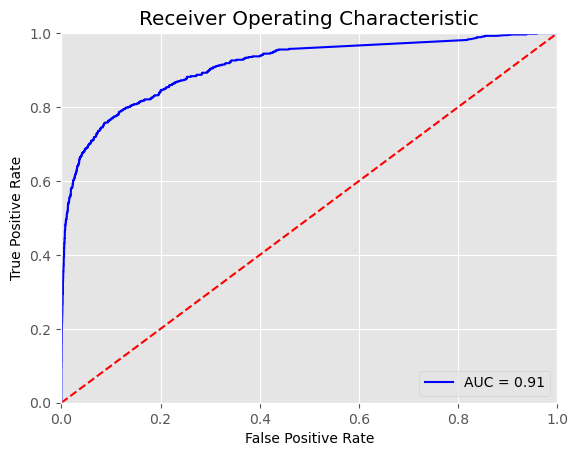

In [216]:
evaluate_model(rf_tuned_optuna, X_test, y_test, "none")
add_to_eval_df(rf_tuned_optuna, "RandomForest-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.1.2 BalancedRandomForest untuned

###### BalancedRandomForest no tuning

In [122]:
brf = BalancedRandomForestClassifier(n_jobs=-1)
brf.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

BalancedRandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 88.38%
------------------------------------------------
Confusion Matrix:
      0    1
0  6946  808
1   156  385
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7754
           1       0.32      0.71      0.44       541

    accuracy                           0.88      8295
   macro avg       0.65      0.80      0.69      8295
weighted avg       0.94      0.88      0.90      8295



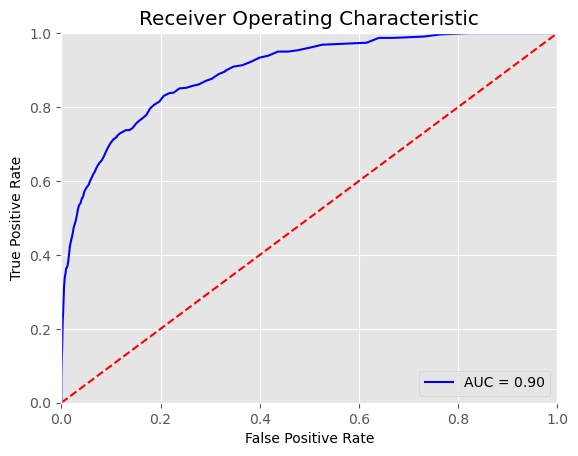

In [217]:
evaluate_model(brf, X_test, y_test, "none")
add_to_eval_df(brf, "BalancedRandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [124]:
cv = cross_val_score(brf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] START .....................................................................
[CV] END ................................ score: (test=0.430) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.464) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.396) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.450) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.9s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.429) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.8s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.449) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.7s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.425) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.7s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.443) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.6s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.426) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.5s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.435) total time=   0.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.5s finished


In [125]:
np.mean(cv)

0.43476764184134975

###### BalancedRandomForest tuning (RandomizedSearchCV)

In [126]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [127]:
random_search = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=0)
random_search.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: 

RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1')

In [128]:
brf_tuned = BalancedRandomForestClassifier(**random_search.best_params_, verbose=0)
brf_tuned.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

BalancedRandomForestClassifier(max_depth=9, max_leaf_nodes=13, n_estimators=200)

none model accuracy for classification is = 88.55%
------------------------------------------------
Confusion Matrix:
      0    1
0  6974  780
1   170  371
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7754
           1       0.32      0.69      0.44       541

    accuracy                           0.89      8295
   macro avg       0.65      0.79      0.69      8295
weighted avg       0.93      0.89      0.90      8295



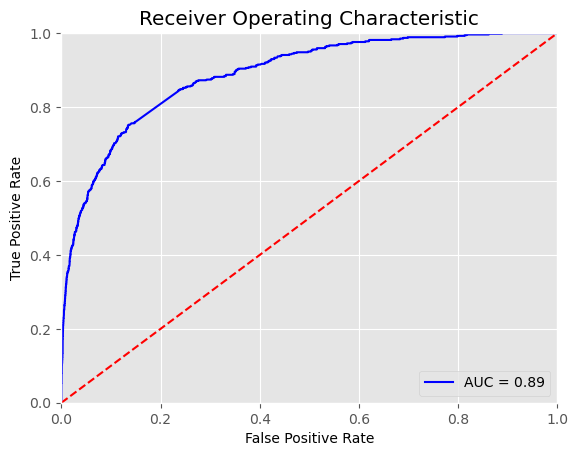

In [218]:
evaluate_model(brf_tuned, X_test, y_test, "none")
add_to_eval_df(brf_tuned, "BalancedRandomForestClassifier-tuned", "clean", X_train, y_train, X_test, y_test)

#### 2.2 Boosting

##### 2.2.1 XGBClassifier

In [130]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 95.03%
------------------------------------------------
Confusion Matrix:
      0    1
0  7714   40
1   372  169
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.81      0.31      0.45       541

    accuracy                           0.95      8295
   macro avg       0.88      0.65      0.71      8295
weighted avg       0.94      0.95      0.94      8295



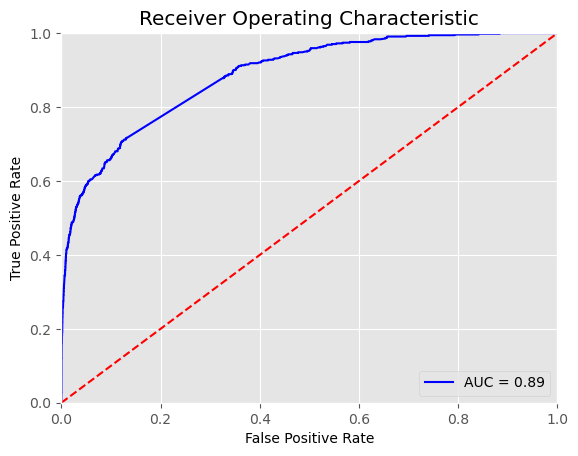

In [219]:
evaluate_model(xgb, X_test, y_test, "none")
add_to_eval_df(xgb, "XGBClassifier", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (GridSearchCV)
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Tuning mit GridSearchCV dauert bei großer param-Liste sehr lange, daher einzelne Schritte mit jeweils nur 1 bis max. 2 params


In [132]:
param_test = {
    'learning_rate': [0.1, 0.01, 0.001],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.32039688186494825, {'learning_rate': 0.1})

none model accuracy for classification is = 94.85%
------------------------------------------------
Confusion Matrix:
      0    1
0  7732   22
1   405  136
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.86      0.25      0.39       541

    accuracy                           0.95      8295
   macro avg       0.91      0.62      0.68      8295
weighted avg       0.94      0.95      0.94      8295



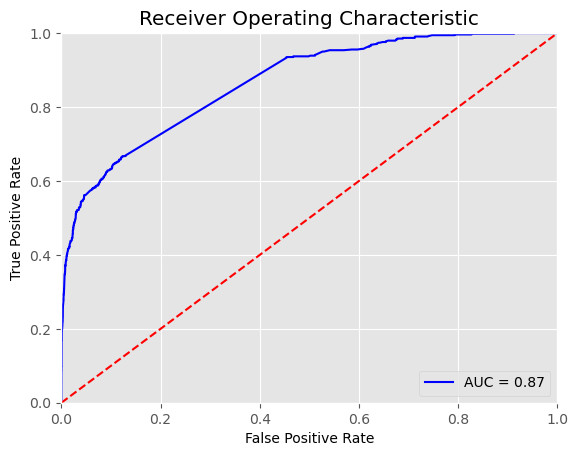

In [133]:
xgb_test = XGBClassifier(learning_rate=0.1)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [134]:
param_test = {
    'n_estimators': range(100, 250, 50),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.37817637241282653, {'n_estimators': 200})

none model accuracy for classification is = 95.01%
------------------------------------------------
Confusion Matrix:
      0    1
0  7722   32
1   382  159
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.83      0.29      0.43       541

    accuracy                           0.95      8295
   macro avg       0.89      0.64      0.70      8295
weighted avg       0.95      0.95      0.94      8295



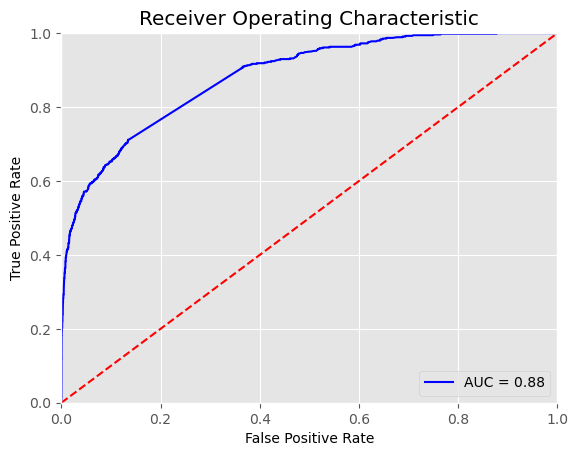

In [135]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [136]:
param_test = {
    'max_depth': range(5, 13, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4298347587940351, {'max_depth': 11})

none model accuracy for classification is = 95.09%
------------------------------------------------
Confusion Matrix:
      0    1
0  7708   46
1   361  180
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.80      0.33      0.47       541

    accuracy                           0.95      8295
   macro avg       0.88      0.66      0.72      8295
weighted avg       0.94      0.95      0.94      8295



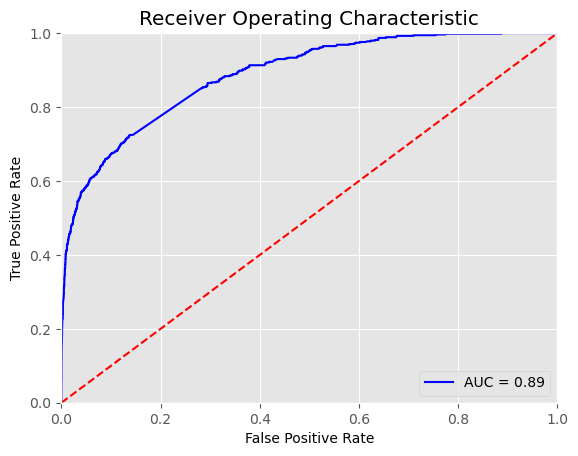

In [137]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [138]:
param_test = {
    'subsample': [0.5, 0.7, 1]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'subsample': 0.7})

none model accuracy for classification is = 95.11%
------------------------------------------------
Confusion Matrix:
      0    1
0  7701   53
1   353  188
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.78      0.35      0.48       541

    accuracy                           0.95      8295
   macro avg       0.87      0.67      0.73      8295
weighted avg       0.94      0.95      0.94      8295



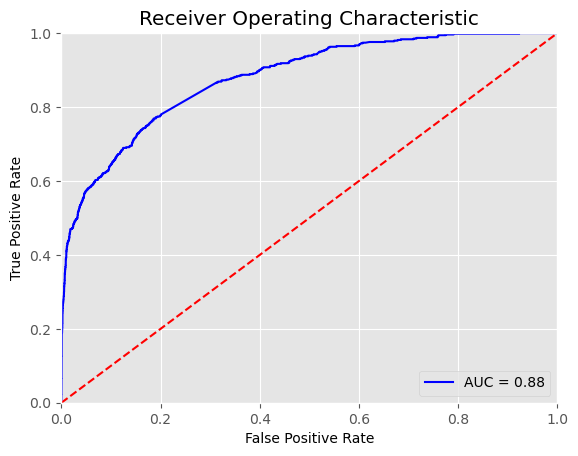

In [139]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [140]:
param_test = {
    'min_child_weight': range(1, 6, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'min_child_weight': 1}) <== kein Einfluss auf Modellperformance

In [141]:
param_test = {
    'gamma': [i / 10.0 for i in range(0, 5)],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'gamma': 0.0}) <== kein Einfluss auf Modellperformance

In [142]:
param_test = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# (0.44114103318625436, {'reg_alpha': 0.01})

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.44114103318625436, {'reg_alpha': 0.01})

In [143]:
param_test = {
    'reg_alpha': [0.005, 0.01, 0.015, 0.02, 0.025]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# # (0.44114103318625436, {'reg_alpha': 0.01})

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.44114103318625436, {'reg_alpha': 0.01})

In [144]:
xgb_tuned_grid = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
xgb_tuned_grid.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 95.07%
------------------------------------------------
Confusion Matrix:
      0    1
0  7700   54
1   355  186
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.78      0.34      0.48       541

    accuracy                           0.95      8295
   macro avg       0.87      0.67      0.73      8295
weighted avg       0.94      0.95      0.94      8295



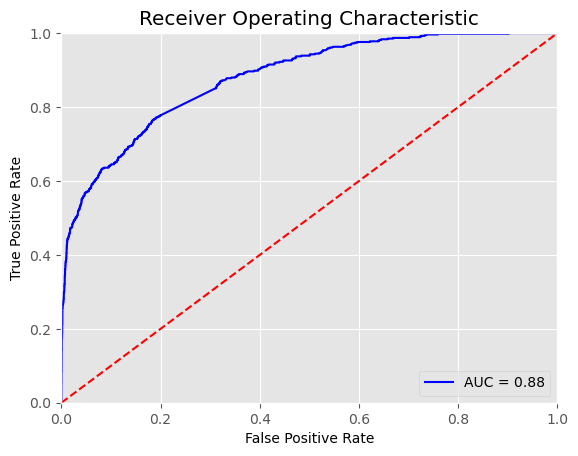

In [220]:
evaluate_model(xgb_tuned_grid, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_grid, "XGBClassifier-tuned-grid", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (RandomizedSearchCV)
Vergleich Modellperformance zwischen GridSearchCV <-> RandomizedSearchCV

In [146]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': range(100, 250, 50),
    'max_depth': range(5, 13, 2),
    'subsample': [0.5, 0.7, 1],
    'min_child_weight': range(1, 6, 2),
    'gamma': [i / 10.0 for i in range(0, 5)],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
}

In [147]:
rsearch = RandomizedSearchCV(XGBClassifier(n_jobs=-1),
                             param_grid,
                             scoring='f1',
                             verbose=1,
                             cv=5,
                             )

In [148]:
rsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': range(5, 13, 2),
                                        'min_child_weight': range(1, 6, 2),
                                        'n_estimators': range(100, 250, 50),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'subsample': [0.5, 0.7, 1]},
                   scoring='f1', verbose=1)

In [149]:
rsearch.best_score_, rsearch.best_params_

(0.3395061099097244,
 {'subsample': 1,
  'reg_alpha': 1e-05,
  'n_estimators': 100,
  'min_child_weight': 1,
  'max_depth': 7,
  'learning_rate': 0.1,
  'gamma': 0.0})

In [150]:
xgb_tuned_rand = XGBClassifier(**rsearch.best_params_, n_jobs=-1)
xgb_tuned_rand.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 94.82%
------------------------------------------------
Confusion Matrix:
      0    1
0  7729   25
1   405  136
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.84      0.25      0.39       541

    accuracy                           0.95      8295
   macro avg       0.90      0.62      0.68      8295
weighted avg       0.94      0.95      0.93      8295



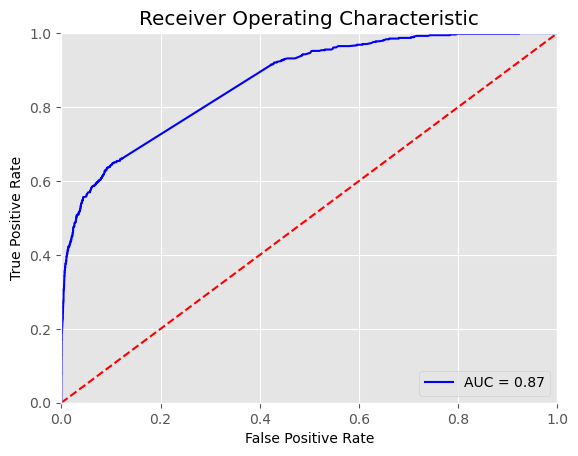

In [221]:
evaluate_model(xgb_tuned_rand, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_rand, "XGBClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (optuna)
https://randomrealizations.com/posts/xgboost-parameter-tuning-with-optuna/
https://www.kaggle.com/code/rzatemizel/optuna-xgboostcv-integration-with-pruning#Intro

In [152]:
def balancedlogloss(predt: np.ndarray, dtrain: xgboost.DMatrix) -> Tuple[str, float]:
    ''' balanced log loss metric.'''
    y = dtrain.get_label()
    target_mean = y.mean()
    w0 = 1 / (1 - target_mean)
    w1 = 1 / target_mean
    sample_weight = [w0 if y == 0 else w1 for y in y]
    loss = log_loss(y, predt, eps=1e-15, sample_weight=sample_weight)

    return 'balancedlogloss', loss

def objective(trial):
    dtrain = xgboost.DMatrix(X_train, label=y_train)

    param = {

        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.8),
        'scale_pos_weight': 509 / 108,
        'random_state': 42,
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 16)
        param["eta"] = trial.suggest_float("eta", 1e-3, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-balancedlogloss")
    history = xgboost.cv(param,
                     dtrain,
                     stratified=True,
                     nfold=5,
                     num_boost_round=10000,
                     early_stopping_rounds=50,
                     custom_metric=balancedlogloss,
                     seed=42,
                     callbacks=[pruning_callback])

    mean_balancedlogloss = history["test-balancedlogloss-mean"].values[-1]
    trial.set_user_attr("n_estimators", len(history))
    return mean_balancedlogloss


AttributeError: 'XGBClassifier' object has no attribute 'DMatrix'

In [165]:
sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study = optuna.create_study(sampler=sampler, pruner=pruner, direction="minimize")
study.optimize(objective, n_trials=5)

[I 2024-11-24 10:55:05,762] A new study created in memory with name: no-name-64164aee-f9ac-4192-b0e6-e126636d0e82
[I 2024-11-24 10:55:45,300] Trial 0 finished with value: 0.31662025610271566 and parameters: {'n_estimators': 200, 'max_features': 'auto', 'max_depth': 70, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.31662025610271566.
[I 2024-11-24 10:55:56,703] Trial 1 finished with value: 0.2374879956461494 and parameters: {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 90, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.2374879956461494.
[I 2024-11-24 10:56:21,914] Trial 2 finished with value: 0.05956033390149031 and parameters: {'n_estimators': 500, 'max_features': 'auto', 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.05956033390149031.
[I 2024-11-24 10:56:28,154] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 300, 'max_features': 'sqrt', 'max_d

Number of finished trials: 5
Best trial:
  Value: 0.0
  Params: 
    n_estimators: 300
    max_features: sqrt
    max_depth: 10
    min_samples_split: 4
    min_samples_leaf: 2


C:\Users\admin\AppData\Local\Temp\ipykernel_20112\993762437.py:13: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)
C:\Users\admin\AppData\Local\Temp\ipykernel_20112\993762437.py:14: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

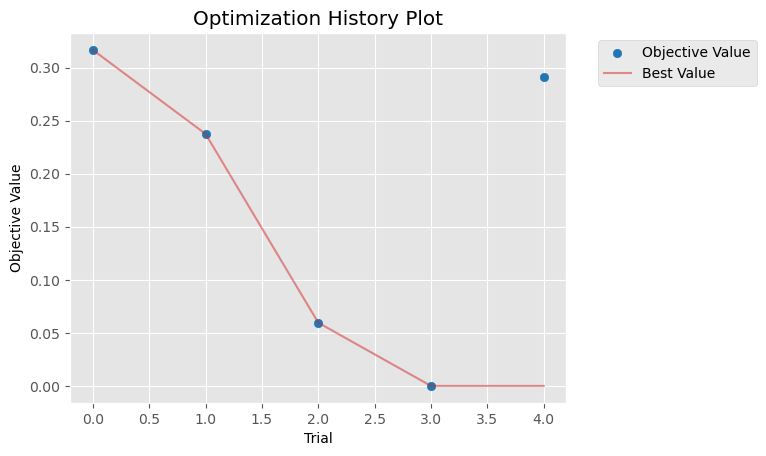

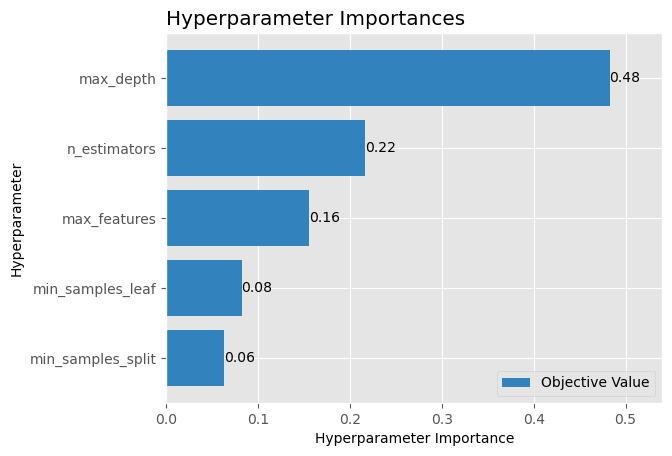

In [168]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

plot_optimization_history(study)
plot_param_importances(study)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:08:11] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


none model accuracy for classification is = 95.37%
------------------------------------------------
Confusion Matrix:
      0    1
0  7694   60
1   324  217
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7754
           1       0.78      0.40      0.53       541

    accuracy                           0.95      8295
   macro avg       0.87      0.70      0.75      8295
weighted avg       0.95      0.95      0.95      8295



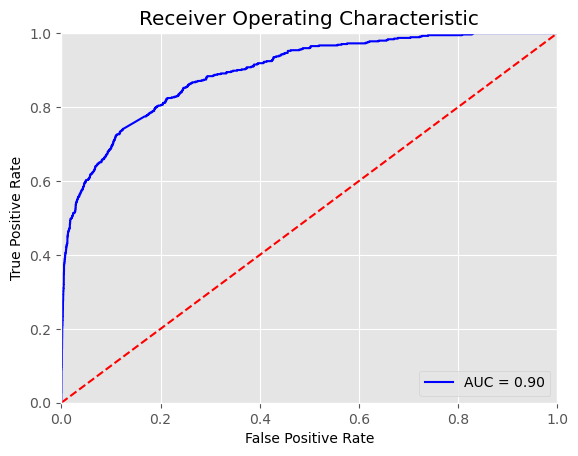

In [170]:
xgb_tuned_optuna = XGBClassifier(**study.best_trial.params)
xgb_tuned_optuna.fit(X_train, y_train)

none model accuracy for classification is = 95.37%
------------------------------------------------
Confusion Matrix:
      0    1
0  7694   60
1   324  217
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7754
           1       0.78      0.40      0.53       541

    accuracy                           0.95      8295
   macro avg       0.87      0.70      0.75      8295
weighted avg       0.95      0.95      0.95      8295



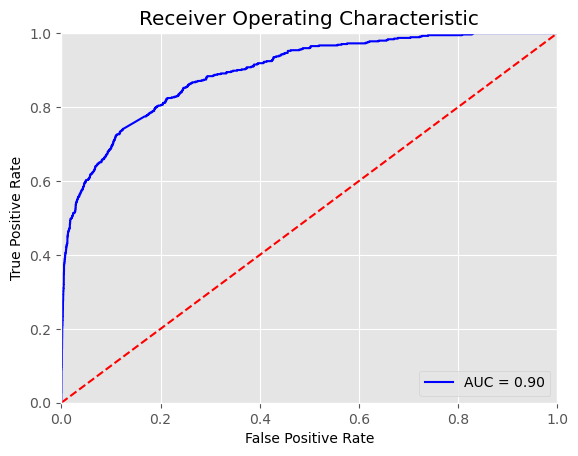

In [222]:
evaluate_model(xgb_tuned_optuna, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_optuna, "XGBClassifier-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 CatBoostClassifier

In [157]:
cat = CatBoostClassifier(iterations=100,
                         depth=5,
                         learning_rate=0.1,
                         loss_function='Logloss',
                         verbose=True)
cat.fit(X_train, y_train)

0:	learn: 0.6816596	total: 1.36s	remaining: 11m 19s
1:	learn: 0.6702015	total: 5.18s	remaining: 21m 29s
2:	learn: 0.6586307	total: 9.2s	remaining: 25m 23s
3:	learn: 0.6478688	total: 13.4s	remaining: 27m 40s
4:	learn: 0.6374998	total: 14.9s	remaining: 24m 39s
5:	learn: 0.6272634	total: 16s	remaining: 21m 56s
6:	learn: 0.6169796	total: 16.9s	remaining: 19m 51s
7:	learn: 0.6069776	total: 17.9s	remaining: 18m 17s
8:	learn: 0.5975432	total: 18.8s	remaining: 17m 2s
9:	learn: 0.5882883	total: 19.7s	remaining: 16m 3s
10:	learn: 0.5789863	total: 20.6s	remaining: 15m 16s
11:	learn: 0.5703713	total: 21.5s	remaining: 14m 35s
12:	learn: 0.5619140	total: 22.5s	remaining: 14m 2s
13:	learn: 0.5532308	total: 23.4s	remaining: 13m 32s
14:	learn: 0.5450940	total: 24.4s	remaining: 13m 7s
15:	learn: 0.5368353	total: 25.3s	remaining: 12m 45s
16:	learn: 0.5290384	total: 26.2s	remaining: 12m 24s
17:	learn: 0.5216955	total: 27.1s	remaining: 12m 5s
18:	learn: 0.5140508	total: 28s	remaining: 11m 49s
19:	learn: 0.

none model accuracy for classification is = 94.58%
------------------------------------------------
Confusion Matrix:
      0    1
0  7743   11
1   439  102
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.90      0.19      0.31       541

    accuracy                           0.95      8295
   macro avg       0.92      0.59      0.64      8295
weighted avg       0.94      0.95      0.93      8295



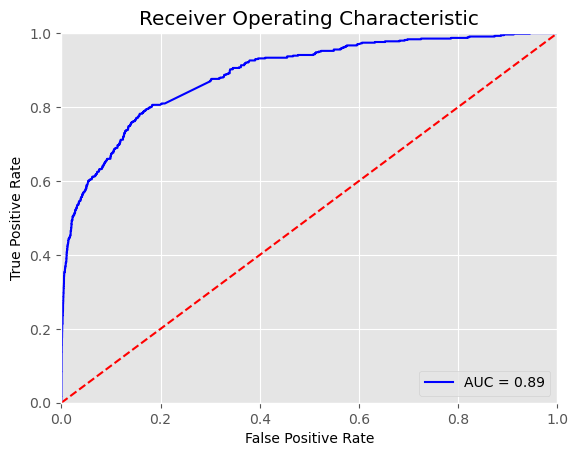

In [223]:
evaluate_model(cat, X_test, y_test, "none")
add_to_eval_df(cat, "CatBoostClassifier", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 LGBMClassifier

In [155]:
light = LGBMClassifier()
light.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1270, number of negative: 18084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33541
[LightGBM] [Info] Number of data points in the train set: 19354, number of used features: 1210
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065620 -> initscore=-2.656011
[LightGBM] [Info] Start training from score -2.656011


LGBMClassifier()

none model accuracy for classification is = 94.82%
------------------------------------------------
Confusion Matrix:
      0    1
0  7700   54
1   376  165
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.75      0.30      0.43       541

    accuracy                           0.95      8295
   macro avg       0.85      0.65      0.70      8295
weighted avg       0.94      0.95      0.94      8295



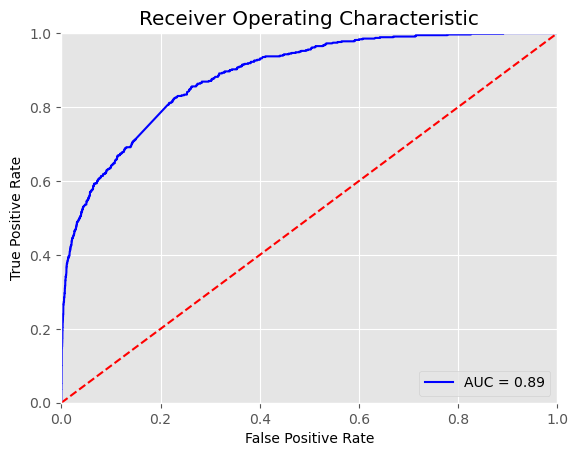

In [224]:
evaluate_model(light, X_test, y_test, "none")
add_to_eval_df(light, "LGBMClassifier", "clean", X_train, y_train, X_test, y_test)

#### 2.3 Stacking

##### 2.3.1 Stacking: RandomForest + LinearSVC

In [209]:
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', LinearSVC(random_state=42))
]
stack = StackingClassifier(estimators=base_models, n_jobs=-1)

In [210]:
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svc', LinearSVC(random_state=42))],
                   n_jobs=-1)

none model accuracy for classification is = 96.07%
------------------------------------------------
Confusion Matrix:
      0    1
0  7682   72
1   254  287
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7754
           1       0.80      0.53      0.64       541

    accuracy                           0.96      8295
   macro avg       0.88      0.76      0.81      8295
weighted avg       0.96      0.96      0.96      8295



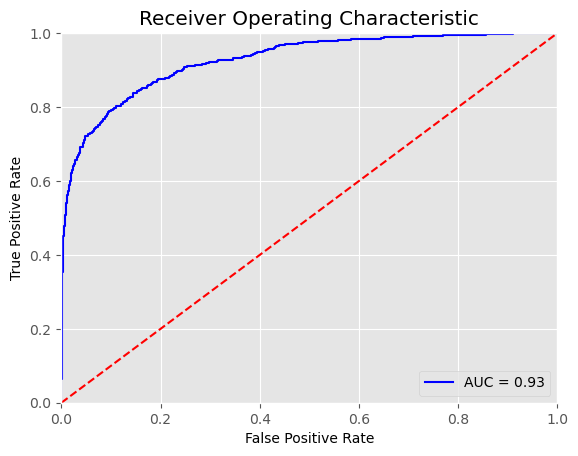

In [213]:
evaluate_model(stack, X_test, y_test, "none")
add_to_eval_df(stack, "StackingClassifier", "clean", X_train, y_train, X_test, y_test)

Vergleich: SVC

In [162]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

In [163]:
evaluate_model(svc, X_test, y_test, "none")
add_to_eval_df(svc, "LinearSVC", "clean", X_train, y_train, X_test, y_test)

none model accuracy for classification is = 95.84%
------------------------------------------------
Confusion Matrix:
      0    1
0  7684   70
1   275  266
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7754
           1       0.79      0.49      0.61       541

    accuracy                           0.96      8295
   macro avg       0.88      0.74      0.79      8295
weighted avg       0.95      0.96      0.95      8295



AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

#### Model comparision

In [225]:
evaluation.sort_values(by=["test_prec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
9,CatBoostClassifier,clean,0.946058,0.915441,0.196063,0.322957,0.945750,0.902655,0.188540,0.311927
2,RandomForest-tuned-optuna,clean,0.972305,0.990642,0.583465,0.734390,0.954430,0.865471,0.356747,0.505236
7,XGBClassifier-tuned-rand,clean,0.951276,0.931398,0.277953,0.428138,0.948162,0.844720,0.251386,0.387464
1,RandomForestClassifier,clean,0.999897,1.000000,0.998425,0.999212,0.957806,0.832753,0.441774,0.577295
5,XGBClassifier,clean,0.959750,0.922547,0.422047,0.579146,0.950332,0.808612,0.312384,0.450667
0,StackingClassifier,clean,0.995040,0.988353,0.935433,0.961165,0.960699,0.799443,0.530499,0.637778
8,XGBClassifier-tuned-optuna,clean,0.978919,0.985360,0.688976,0.810936,0.953707,0.783394,0.401109,0.530562
6,XGBClassifier-tuned-grid,clean,0.962333,0.921997,0.465354,0.618524,0.950693,0.775000,0.343808,0.476312
10,LGBMClassifier,clean,0.961713,0.927302,0.451969,0.607729,0.948162,0.753425,0.304991,0.434211
3,BalancedRandomForestClassifier,clean,0.905549,0.409942,1.000000,0.581502,0.883785,0.322716,0.711645,0.444060


In [226]:
evaluation.sort_values(by=["test_rec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
3,BalancedRandomForestClassifier,clean,0.905549,0.409942,1.000000,0.581502,0.883785,0.322716,0.711645,0.444060
4,BalancedRandomForestClassifier-tuned,clean,0.885398,0.334266,0.752756,0.462954,0.885473,0.322328,0.685767,0.438534
0,StackingClassifier,clean,0.995040,0.988353,0.935433,0.961165,0.960699,0.799443,0.530499,0.637778
1,RandomForestClassifier,clean,0.999897,1.000000,0.998425,0.999212,0.957806,0.832753,0.441774,0.577295
8,XGBClassifier-tuned-optuna,clean,0.978919,0.985360,0.688976,0.810936,0.953707,0.783394,0.401109,0.530562
2,RandomForest-tuned-optuna,clean,0.972305,0.990642,0.583465,0.734390,0.954430,0.865471,0.356747,0.505236
6,XGBClassifier-tuned-grid,clean,0.962333,0.921997,0.465354,0.618524,0.950693,0.775000,0.343808,0.476312
5,XGBClassifier,clean,0.959750,0.922547,0.422047,0.579146,0.950332,0.808612,0.312384,0.450667
10,LGBMClassifier,clean,0.961713,0.927302,0.451969,0.607729,0.948162,0.753425,0.304991,0.434211
7,XGBClassifier-tuned-rand,clean,0.951276,0.931398,0.277953,0.428138,0.948162,0.844720,0.251386,0.387464


In [227]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
0,StackingClassifier,clean,0.995040,0.988353,0.935433,0.961165,0.960699,0.799443,0.530499,0.637778
1,RandomForestClassifier,clean,0.999897,1.000000,0.998425,0.999212,0.957806,0.832753,0.441774,0.577295
8,XGBClassifier-tuned-optuna,clean,0.978919,0.985360,0.688976,0.810936,0.953707,0.783394,0.401109,0.530562
2,RandomForest-tuned-optuna,clean,0.972305,0.990642,0.583465,0.734390,0.954430,0.865471,0.356747,0.505236
6,XGBClassifier-tuned-grid,clean,0.962333,0.921997,0.465354,0.618524,0.950693,0.775000,0.343808,0.476312
5,XGBClassifier,clean,0.959750,0.922547,0.422047,0.579146,0.950332,0.808612,0.312384,0.450667
3,BalancedRandomForestClassifier,clean,0.905549,0.409942,1.000000,0.581502,0.883785,0.322716,0.711645,0.444060
4,BalancedRandomForestClassifier-tuned,clean,0.885398,0.334266,0.752756,0.462954,0.885473,0.322328,0.685767,0.438534
10,LGBMClassifier,clean,0.961713,0.927302,0.451969,0.607729,0.948162,0.753425,0.304991,0.434211
7,XGBClassifier-tuned-rand,clean,0.951276,0.931398,0.277953,0.428138,0.948162,0.844720,0.251386,0.387464


In [228]:
evaluation['vectorize_variant'] = "tfidf"
evaluation = evaluation[['model',
 'variant',
 'vectorize_variant',
 'train_acc',
 'train_prec',
 'train_rec',
 'train_f1',
 'test_acc',
 'test_prec',
 'test_rec',
 'test_f1']]

outname = 'evaluation_tfidf.csv'

outdir = './eval_data'
if not os.path.exists(outdir):
    os.mkdir(outdir)

fullname = os.path.join(outdir, outname)

evaluation.to_csv(fullname)